In [2]:
import os
import pickle

import numpy as np
import pandas as pd

# preprocessing
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer


# models
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# finetuning
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

# evaluation metrics
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)


In [3]:
data_filename = os.path.join(os.getcwd(), 'data', 'S1File.csv')
metadata_filename = os.path.join(os.getcwd(), 'data', 'metadata.csv')

In [4]:
df = pd.read_csv(data_filename)
metadata = pd.read_csv(metadata_filename)

In [5]:
features = metadata.variable.to_list()
label = 'UCX_abnormal'  # UCX test result
diagnosis = 'UTI_diag'  # ED diagnosis

# Map UCX and clinical diagnosis to int
df[label] = df[label].map({'yes': 1, 'no': 0})
df[diagnosis] = df[diagnosis].map({'Yes': 1, 'No': 0})

# Reorder columns
df = df[[label] + [diagnosis] + features]

# Data Preprocessing


In [6]:
def trim_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    First, drop the columns with not_reported values > 10%
    Then, drop observations with not_reported or other values
    return cleaned dataframe
    """
    # Drop the columns with not_reported values > 10%
    drop = []
    demo = ['age', 'gender', 'race', 'ethnicity', 'lang',
            'employStatus', 'maritalStatus', 'chief_complaint']
    cols = [i for i in df.columns if i not in demo]
    for col in cols:
        ratio = df[col][df[col] == 'not_reported'].count()/df.shape[0]*100
        if ratio > 0.1:
            drop.append(col)
    df = df.drop(labels=drop, axis=1)

    # Drop observations with not_reported or other values
    df= df[~df.apply(lambda row: row =='not_reported').any(axis=1)]
    df= df[~df.apply(lambda row: row =='other').any(axis=1)]
    df= df[~df.apply(lambda row: row =='4+').any(axis=1)]

    # Convert numeric features to float
    num = ['ua_ph', 'ua_spec_grav', 'age']
    for col in num:
        mean = df[(df[col] != 'not_reported') & (df[col]!= 'other')][col].astype(
            'float').mean()
        df[col] = df[col].replace('not_reported', mean)
        df[col] = df[col].astype(float)

    return df

In [7]:
def encode_features(df: pd.DataFrame) -> tuple[pd.DataFrame, ColumnTransformer]:
    """
    Input the cleaned dataframe,
    OneHotEncode the categorical (non-ordinal) attributes,
    OrdinalEncode the ordinal attributes
    return the final dataframe
    """

    other = ['ua_ph', 'ua_spec_grav', 'age']
    ord = ['ua_blood', 'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_protein']
    onehot = ['chief_complaint', 'race', 'ethnicity',
              'maritalStatus', 'employStatus']
    label = [i for i in df.columns if i not in ord+other+onehot]

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), onehot),
            ('label', OrdinalEncoder(), label),
            ('ordinal', OrdinalEncoder(categories=[
             ['negative', 'small', 'moderate', 'large']]* len(ord)), ord)
        ])

    transformed = preprocessor.fit_transform(df)

    onehot_col_names = preprocessor.named_transformers_[
        'onehot'].get_feature_names_out(onehot)
    new_column_names = list(onehot_col_names) + label + ord
    # Preserve the original index
    df_transformed = pd.DataFrame(
        transformed, columns=new_column_names, index=df.index)  # type: ignore

    df_final = pd.concat([df[other], df_transformed], axis=1)

    return df_final, preprocessor

In [8]:
df_cleaned = trim_missing(df)
df_cleaned.head()

,UCX_abnormal,UTI_diag,ua_blood,ua_color,ua_glucose,ua_ketones,ua_leuk,ua_nitrite,ua_ph,ua_protein,...,MISCELLANEOUS_MEDICAL_SUPPLIES__DEVICES__NON_DRUG,MUSCLE_RELAXANTS,PRE_NATAL_VITAMINS,PSYCHOTHERAPEUTIC_DRUGS,SEDATIVE_HYPNOTICS,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS
0,1,1,negative,yellow,negative,negative,small,negative,7.5,negative,...,No,No,No,No,No,No,No,No,No,No
2,1,0,negative,yellow,negative,negative,small,negative,5.0,small,...,No,No,No,Yes,Yes,No,No,Yes,Yes,No
3,1,1,negative,yellow,negative,negative,large,negative,5.5,small,...,No,No,No,No,No,No,No,No,No,Yes
4,0,0,negative,orange,negative,small,small,positive,6.0,moderate,...,No,No,No,No,No,No,No,No,No,No
5,1,0,large,yellow,negative,large,small,negative,6.0,small,...,No,No,No,No,No,No,No,No,No,No


In [9]:
X, encoder = encode_features(df_cleaned.iloc[:, 2:])
Y = df_cleaned.iloc[:, :2]
print(f'Feature X shape: {X.shape}')
print(f'Label Y shape: {Y.shape}, where'
      f'\n\tthe first column is true label ({label})'
      f'\n\tthe second column is ed diagnosis ({diagnosis})')

Feature X shape: (59792, 153)
Label Y shape: (59792, 2), where
	the first column is true label (UCX_abnormal)
	the second column is ed diagnosis (UTI_diag)


In [10]:
X.head()

,ua_ph,ua_spec_grav,age,chief_complaint_ABDOMINAL PAIN,chief_complaint_ALTERED MENTAL STATUS,chief_complaint_BACK PAIN,chief_complaint_CHEST PAIN,chief_complaint_DIZZINESS,chief_complaint_DYSURIA,chief_complaint_EMESIS,...,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS,ua_blood,ua_glucose,ua_ketones,ua_leuk,ua_protein
0,7.5,1.020,83.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5.0,1.016,78.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,5.5,1.016,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0
4,6.0,1.030,55.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
5,6.0,1.030,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,1.0,1.0


In [11]:
Y.head()

,UCX_abnormal,UTI_diag
0,1,1
2,1,0
3,1,1
4,0,0
5,1,0


# Training


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)
y_train, y_test = Y_train[label], Y_test[label]

assert y_train.name == label
assert y_test.name == label

In [13]:
def model_performace(model, X_train, X_test, y_train, y_test,
                     ljust_len=30):
    print('Training accuracy: {}'.format(
        "%.4f" % model.score(X_train, y_train)))

    male, female = X_test.gender == 1, X_test.gender == 0
    print('Test accuracy:\n\t{}{}\n\t{}{}\n\t{}{}'.format(
        'General population'.ljust(ljust_len),
        "%.4f" % model.score(X_test, y_test),
        'Male'.ljust(ljust_len),
        "%.4f" % model.score(X_test[male], y_test[male]),
        'Female'.ljust(ljust_len),
        "%.4f" % model.score(X_test[female], y_test[female])))

    employ_cols = X_test.columns[X_test.columns.str.contains('employStatus')]
    for employ_col in employ_cols:
        rows = X_test[employ_col] == 1
        print('\t{}{}'.format(
            employ_col.split('_')[-1].ljust(ljust_len),
            "%.4f" % model.score(X_test[rows], y_test[rows])))

    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print('\n', report)

### Logistic Regression


In [ ]:
model = make_pipeline(MinMaxScaler(),LogisticRegression(n_jobs=-1, max_iter=2000))
model.fit(X_train, y_train)

In [ ]:
model_performace(model, X_train, X_test, y_train, y_test)

### Naive Bayes


In [ ]:
model = make_pipeline(MinMaxScaler(),GaussianNB())
model.fit(X_train, y_train)

In [ ]:
model_performace(model, X_train, X_test, y_train, y_test)

### kNN


In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 21))}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_k

In [ ]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)
model_performace(model, X_train, X_test, y_train, y_test)

### MLP


In [ ]:
model = MLPClassifier(hidden_layer_sizes=(512, 512, 512),
                      max_iter=50, verbose=True)
model.fit(X_train, y_train)

In [ ]:
model_performace(model, X_train, X_test, y_train, y_test)

### SVM


In [ ]:
model = SVC(shrinking=False, verbose=True)
model.fit(X_train, y_train)

In [ ]:
model_performace(model, X_train, X_test, y_train, y_test)

### Random Forest

In [21]:
# no need for scaler
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)
model_rf.fit(X_train, y_train)
model_performace(model_rf, X_train, X_test, y_train, y_test)

Training accuracy: 0.9989
Test accuracy:
	General population            0.8492
	Male                          0.9047
	Female                        0.8244
	Disabled                      0.8605
	Full Time                     0.8703
	Not Employed                  0.8545
	On Active Military Duty       1.0000
	Part Time                     0.8301
	Retired                       0.8298
	Self Employed                 0.8567
	Student - Full Time           0.8629
	Student - Part Time           0.8571
	Unknown                       0.8824

               precision    recall  f1-score   support

           0       0.86      0.96      0.91      9277
           1       0.77      0.47      0.58      2682

    accuracy                           0.85     11959
   macro avg       0.82      0.71      0.74     11959
weighted avg       0.84      0.85      0.83     11959



In [ ]:
# dimension reduction for RandomForrest
# import plotly.express as px
# mmscaler = MinMaxScaler()
# X_train_scaled = mmscaler.fit_transform(X_train)
# pca = PCA(n_components=100)
# X_train_pca = pca.fit_transform(X_train_scaled)

# exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

# px.area(
#     x=range(1, exp_var_cumul.shape[0] + 1),
#     y=exp_var_cumul,
#     labels={"x": "# Components", "y": "Explained Variance"}
# )
# pipeline of MinMaxScaler + PCA
# model_rf = Pipeline([('mm', MinMaxScaler()),
#                  ('pca', PCA(n_components=90)),
#                  ('rf', RandomForestClassifier())
#                 ])

# model_rf.fit(X_train, y_train)
# model_performace(model, X_train, X_test, y_train, y_test)
# results are the same for no feature engineering

In [18]:
# precision on 1 decreased, recall increased
param_grid = {
    'max_depth': [40,80,None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    "n_estimators" : [300,500],
    'n_jobs': [-1]
}


rf_random = GridSearchCV(estimator = RandomForestClassifier(), scoring = 'f1',param_grid = param_grid, cv = 3)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
model_performace(best_rf, X_train, X_test, y_train, y_test)

Training accuracy: 0.9769
Test accuracy:
	General population            0.8478
	Male                          0.9075
	Female                        0.8212
	Disabled                      0.8530
	Full Time                     0.8636
	Not Employed                  0.8538
	On Active Military Duty       0.5000
	Part Time                     0.8415
	Retired                       0.8295
	Self Employed                 0.8597
	Student - Full Time           0.8710
	Student - Part Time           0.8095
	Unknown                       0.8824

               precision    recall  f1-score   support

           0       0.87      0.95      0.91      9277
           1       0.73      0.51      0.60      2682

    accuracy                           0.85     11959
   macro avg       0.80      0.73      0.75     11959
weighted avg       0.84      0.85      0.84     11959



In [22]:
best_rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=80, max_features=None, min_samples_leaf=2,
                       min_samples_split=4, n_estimators=300, n_jobs=-1)>

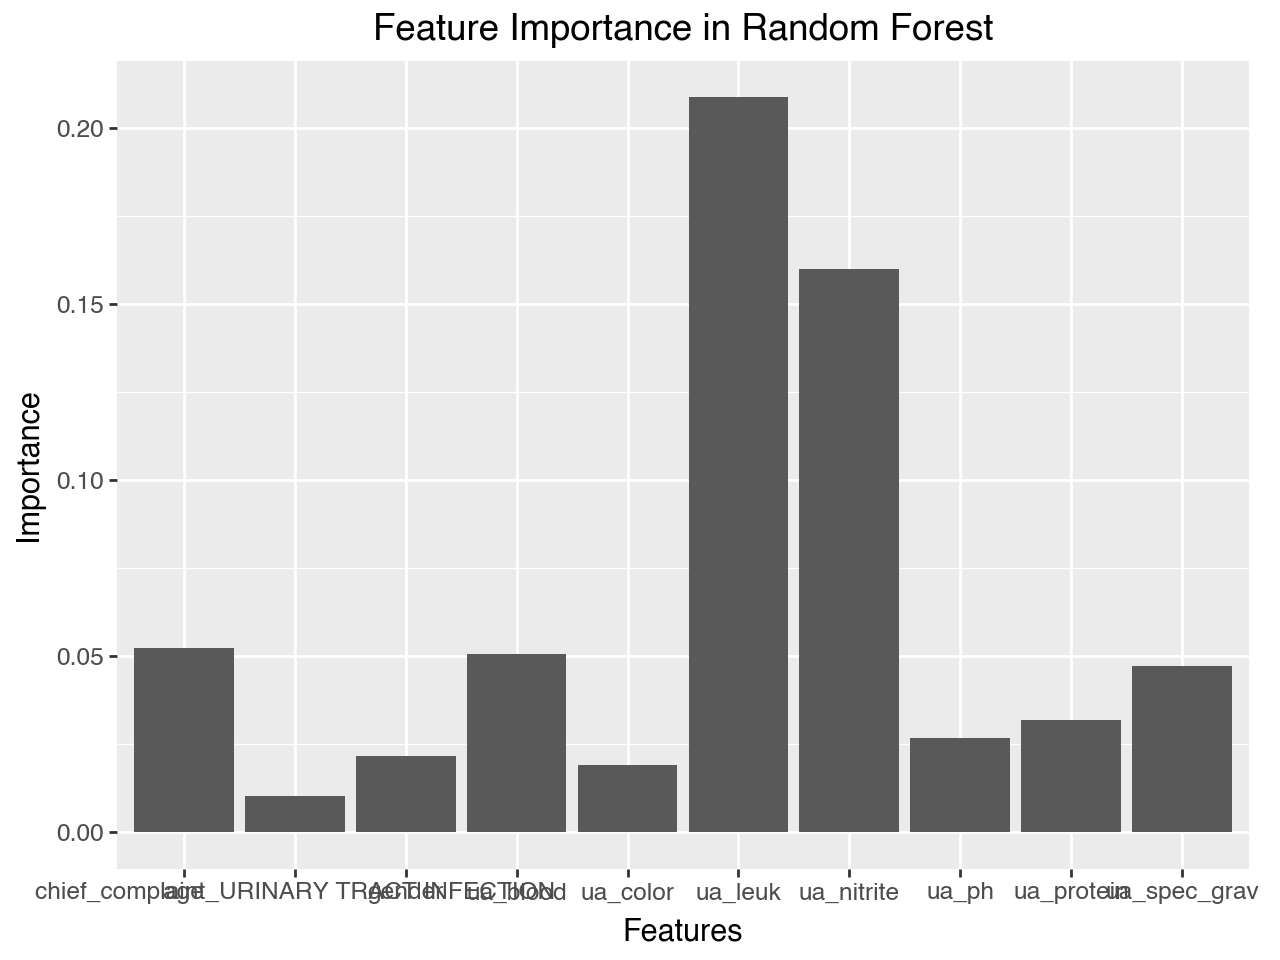

In [28]:
from plotnine import ggplot, aes, geom_bar, labs,geom_point, geom_abline

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
top_10_features = feature_importance.head(10)
# Plot feature importance using plotnine
plot = (ggplot(top_10_features, aes(x='Feature', y='Importance')) +
        geom_bar(stat='identity') +
        labs(title="Feature Importance in Random Forest", x="Features", y="Importance"))
plot

In [30]:
param_grid = {
    'max_depth': [30,40,50],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [4,6,8],
    "n_estimators" : [100,200,300],
    'n_jobs': [-1]
}


rf_random = GridSearchCV(estimator = RandomForestClassifier(), scoring = 'f1',param_grid = param_grid, cv = 3)
rf_random.fit(X_train, y_train)
best_rf_2 = rf_random.best_estimator_
model_performace(best_rf_2, X_train, X_test, y_train, y_test)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast


Training accuracy: 0.8911
Test accuracy:
	General population            0.8449
	Male                          0.9020
	Female                        0.8194
	Disabled                      0.8577
	Full Time                     0.8683
	Not Employed                  0.8535
	On Active Military Duty       1.0000
	Part Time                     0.8267
	Retired                       0.8205
	Self Employed                 0.8507
	Student - Full Time           0.8683
	Student - Part Time           0.8571
	Unknown                       0.7647

               precision    recall  f1-score   support

           0       0.85      0.97      0.91      9277
           1       0.79      0.42      0.55      2682

    accuracy                           0.84     11959
   macro avg       0.82      0.70      0.73     11959
weighted avg       0.84      0.84      0.83     11959



### LightGBM

In [ ]:
model_performace(best_rf, X_train, X_test, y_train, y_test)

In [ ]:
param_grid = {
"num_leaves": [31, 63, 127],
"min_data_in_leaf": [10,20,30],
"early_stopping_rounds":[1,3,5],
"max_depth": [-1, 3, 5],
"max_bin": [150,200,250,300],
"subsample": [0.8, 1.0]
}
model_lgb = LGBMClassifier(device = 'gpu',objective="binary", metric="binary_logloss", random_state=42)

grid_search = GridSearchCV(estimator = model_lgb, scoring = 'precision', param_distributions = param_grid, n_iter = 100, cv = 3)
grid_search.fit(X_train, y_train)
best_lgb = grid_search.best_estimator_
model_performace(best_lgb, X_train, X_test, y_train, y_test)

# Save Models


In [ ]:
# models = {}

In [ ]:
# # Store model results
# models['logistic regression'] = {
#     'model': model,
#     'training accuracy': model.score(X_train, y_train),
#     'test accuracy': model.score(X_test, y_test),
#     'precision': precision_score(y_test, y_pred),
#     'recall': recall_score(y_test, y_pred),
#     'f1': f1_score(y_test, y_pred)
# }

In [ ]:
# # Save models to local file
# with open('model_performances.pkl', 'wb') as f:
#     pickle.dump(models, f)